## Actual start of notebook

In this lab, we will be treading some old grounds with a new perspective. 
Functional (fMRI) and diffusion (dMRI) data require similar processing such as motion correction, denoising, masking, and modelling. 
We will complete this lab using only python commands, which means we will see familiar FSL commands in a new light.

**Learning Objectives**
- Learn the steps to process diffusion weighted data
- Be aware of some common gotchas! (e.g. rotating B vectors and data representations)
- Learn Nipype basics


In [ ]:
%%bash
# lab prep
# need access to ants utilities
path='export PATH="/usr/lib/ants:$PATH"'
proper_path=$(grep "${path}" ~/.bashrc)
if [[ ${proper_path} == "" ]]; then
    echo ${path} >> ~/.bashrc
fi


# need another python module
pip install scikit-image

# exit the notebook, and type source ~/.bashrc in the terminal and open the notebook again.

In [1]:
# notebook prep
%matplotlib inline
# modules to preprocess the data
from nipype.workflows.dmri.fsl.artifacts import hmc_pipeline
from dwi_preprocess import ecc_pipeline
from nipype.workflows.dmri.fsl.utils import rotate_bvecs

# nipype utilities for building workflows
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces import utility as niu

# for various file operations
import os

# making a mask
from dipy.segment.mask import median_otsu

# for loading nifti files into python
import nibabel as nib

# for applying mathematical oeprations to nifti objects
import numpy as np

# visualizing results
from nilearn import plotting

180417-17:01:34,525 duecredit ERROR:
	 Failed to import duecredit due to No module named 'duecredit'


/usr/local/miniconda3/lib/python3.6/site-packages/nipype/workflows/dmri/mrtrix/group_connectivity.py:16: UserWarning: cmp not installed
  warnings.warn('cmp not installed')


## Step 1: Masking
We have seen masking using [bet](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide), but sometimes a simpler method suffices. The [median otsu](https://en.wikipedia.org/wiki/Otsu%27s_method) is another image processing algorithm that's found use in the world of MRI.We will be using [dipy's implementation of this algorithm](http://nipy.org/dipy/reference/dipy.segment.html#dipy.segment.mask.median_otsu)

In [10]:
# the input file
dwi_nii = './sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz'

# load the file into python
dwi_img = nib.load(dwi_nii)

# access the 4D data matrix in the python object
dwi_data = dwi_img.get_data()

# mask the data
_, mask_data = median_otsu(dwi_data)

# make the mask a python image object
mask_img = nib.Nifti1Image(mask_data.astype(np.float32), dwi_img.affine)

# set the output directory
fout = os.path.join(os.getcwd(), 
                    'derivatives/otsu_mask/sub-999/ses-activepre/dwi')

# make the output directory
os.makedirs(fout, exist_ok=True)

# set the output name of the file
fname = 'sub-999_ses-activepre_dwi_mask.nii.gz'
out_fname = os.path.join(fout, fname)
# save the output as a nifti file
fmask = nib.save(mask_img, out_fname)

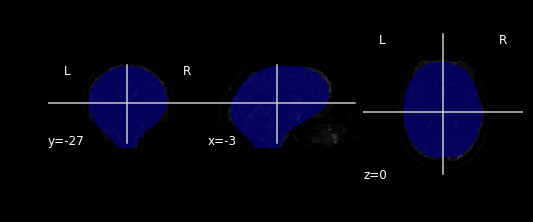

In [11]:
# visualize the mask
# grab the first volume of the dwi (a B0)
first_vol_data = dwi_data[:,:,:,0]
# make the volume a python nifti object
first_vol_img = nib.Nifti1Image(first_vol_data.astype(np.float32), dwi_img.affine)
# plot the mask
plotting.plot_roi(roi_img=out_fname, bg_img=first_vol_img)

## Step 2: Head Motion/Eddy Current Correction
Just as people move during resting state or task fmri, they will also move when we collect diffusion weighted imaging. In addition, due to [eddy currents](http://mriquestions.com/eddy-current-problems.html), there are shears in the data unique to each magnetic vector (direction) applied. In our example  scan, we have 64 unique directions, and therefor the data are sheared in 64 unique ways. To convince ourselves of this, let's take a look at some data.

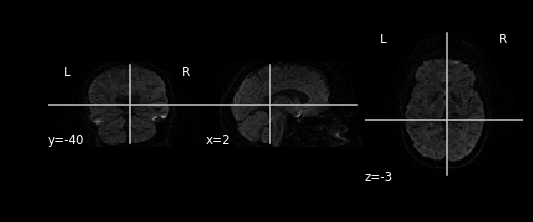

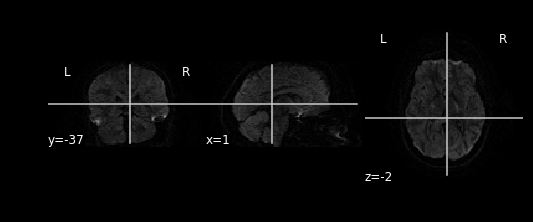

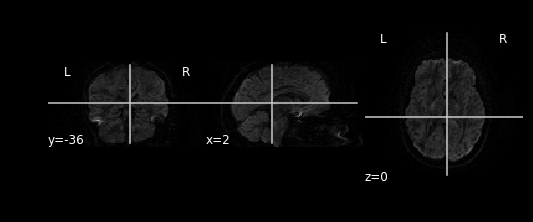

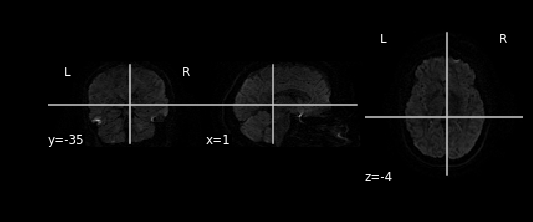

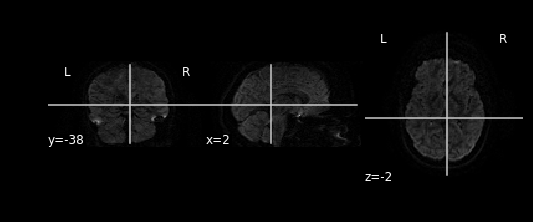

In [12]:
for vol_idx in range(10, 60, 10):
    tmp_img = nib.Nifti1Image(dwi_data[:,:,:,vol_idx], dwi_img.affine)
    plotting.plot_anat(tmp_img)

Below we are going to setup a "[workflow](https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html)" using [nipype](http://nipype.readthedocs.io/en/latest/). A workflow is a set of processing steps we would like to run together. For example, FEAT completes multiple steps for slice-timing correction, motion correction, spatial smoothing, temporal filtering, etc. Nipype gives us the ability to contruct these workflows all within python.

### DO NOT RUN THE CODE IN THE BELOW BLOCK (I've ran it for you...it takes 30-45 minutes)

In [2]:
# make a working directory for intermediate outputs
os.makedirs('work', exist_ok=True)
# set a variable to that working directory
work_dir = os.path.join(os.getcwd(), 'work')

# set the templates for the files we want to match
templates = dict(dwi_nii="sub-{sub_label}/ses-{ses_label}/dwi/sub-{sub_label}_ses-{ses_label}_dwi.nii.gz",
                 bvals="sub-{sub_label}/ses-{ses_label}/dwi/sub-{sub_label}_ses-{ses_label}_dwi.bval",
                 bvecs="sub-{sub_label}/ses-{ses_label}/dwi/sub-{sub_label}_ses-{ses_label}_dwi.bvec",
                 mask="derivatives/otsu_mask/sub-{sub_label}/ses-{ses_label}/dwi/sub-{sub_label}_ses-{ses_label}_dwi_mask.nii.gz")

# make the node to match the templates
inputnode = pe.Node(nio.SelectFiles(templates), name='inputnode')

# set the node inputs to the desired inputs
inputnode.inputs.base_directory = os.getcwd()
inputnode.inputs.sub_label = '999'
inputnode.inputs.ses_label = 'activepre'


# head motion correction workflow
hmc_wf = hmc_pipeline(name='hmc_wf')

# eddy current correction workflow
ecc_wf = ecc_pipeline(name='ecc_wf')

# rotate the transformed b vectors
rotate_bvec = pe.Node(
    niu.Function(
        input_names=['in_bvec', 'in_matrix'],
        output_names=['out_file'],
        function=rotate_bvecs),
        name='rotate_bvec')

# collect the outputs
ds_output = pe.Node(nio.DataSink(), name='ds_output')
ds_output.inputs.base_directory = os.path.join(os.getcwd(), 'derivatives/preproc/sub-999/ses-activepre/dwi/')

# the workflow
dwi_preproc = pe.Workflow(name='dwi_preproc')

dwi_preproc.connect([
    (inputnode, hmc_wf, [('dwi_nii', 'inputnode.in_file'),
                         ('mask', 'inputnode.in_mask'),
                         ('bvals', 'inputnode.in_bval'),
                         ('bvecs', 'inputnode.in_bvec')]),
    (inputnode, ecc_wf, [('bvals', 'inputnode.in_bval'),
                         ('dwi_nii', 'inputnode.in_file'),
                         ('mask', 'inputnode.in_mask')]),
    (hmc_wf, ecc_wf, [('outputnode.out_xfms', 'inputnode.in_xfms')]),
    (ecc_wf, rotate_bvec, [('outputnode.out_xfms', 'in_matrix')]),
    (inputnode, rotate_bvec, [('bvecs', 'in_bvec')]),
    (rotate_bvec, ds_output, [('out_file', 'bvec')]),
    (ecc_wf, ds_output, [('outputnode.out_file', 'dwi_eddy_corr')]),
])

# place all the intermediate results in the work directory
dwi_preproc.base_dir = work_dir
# run the workflow
dwi_preproc.run()
# make an illustration of the workflow
dwi_preproc.write_graph()

180417-17:01:44,808 workflow INFO:
	 Workflow dwi_preproc settings: ['check', 'execution', 'logging', 'monitoring']
180417-17:01:44,848 workflow INFO:
	 Running serially.
180417-17:01:44,850 workflow INFO:
	 [Node] Setting-up "dwi_preproc.inputnode" in "/home/james/dipy_test/work/dwi_preproc/inputnode".
180417-17:01:44,855 workflow INFO:
	 [Node] Running "inputnode" ("nipype.interfaces.io.SelectFiles")
180417-17:01:44,867 workflow INFO:
	 [Node] Finished "dwi_preproc.inputnode".
180417-17:01:44,869 workflow INFO:
	 [Node] Setting-up "dwi_preproc.ecc_wf.DWICoregistration.MskDilate" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate".
180417-17:01:44,872 workflow INFO:
	 [Node] Cached "dwi_preproc.ecc_wf.DWICoregistration.MskDilate" - collecting precomputed outputs
180417-17:01:44,873 workflow INFO:
	 [Node] "dwi_preproc.ecc_wf.DWICoregistration.MskDilate" found cached.
180417-17:01:44,873 workflow INFO:
	 [Node] Setting-up "dwi_preproc.ecc_wf.ExtractDWI" in "/

	 [Node] "_CoRegistration1" found cached.
180417-17:01:45,185 workflow INFO:
	 [Node] Setting-up "_CoRegistration2" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration2".
180417-17:01:45,192 workflow INFO:
	 [Node] Cached "_CoRegistration2" - collecting precomputed outputs
180417-17:01:45,195 workflow INFO:
	 [Node] "_CoRegistration2" found cached.
180417-17:01:45,199 workflow INFO:
	 [Node] Setting-up "_CoRegistration3" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration3".
180417-17:01:45,203 workflow INFO:
	 [Node] Cached "_CoRegistration3" - collecting precomputed outputs
180417-17:01:45,206 workflow INFO:
	 [Node] "_CoRegistration3" found cached.
180417-17:01:45,216 workflow INFO:
	 [Node] Setting-up "_CoRegistration4" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration4".
180417-17:01:45,222 workflow INFO:
	 [Node] Ca

180417-17:02:03,451 workflow INFO:
	 [Node] Finished "_CoRegistration20".
180417-17:02:03,455 workflow INFO:
	 [Node] Setting-up "_CoRegistration21" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration21".
180417-17:02:03,458 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration21".
180417-17:02:03,468 workflow INFO:
	 [Node] Running "_CoRegistration21" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize21/vol0021_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0021_enh_flirt.nii.gz -omat vol0021_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration30/vol0030_enh_flirt.mat -inweight /ho

180417-17:02:56,673 workflow INFO:
	 [Node] Setting-up "_CoRegistration27" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration27".
180417-17:02:56,678 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration27".
180417-17:02:56,687 workflow INFO:
	 [Node] Running "_CoRegistration27" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize27/vol0027_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0027_enh_flirt.nii.gz -omat vol0027_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration36/vol0036_enh_flirt.mat -inweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub

180417-17:03:51,651 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration33".
180417-17:03:51,662 workflow INFO:
	 [Node] Running "_CoRegistration33" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize33/vol0033_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0033_enh_flirt.nii.gz -omat vol0033_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration42/vol0042_enh_flirt.mat -inweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_maths.nii.gz -interp spline -nosearch -refweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_math

180417-17:04:47,605 workflow INFO:
	 [Node] Running "_CoRegistration39" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize39/vol0039_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0039_enh_flirt.nii.gz -omat vol0039_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration48/vol0048_enh_flirt.mat -inweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_maths.nii.gz -interp spline -nosearch -refweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_maths.nii.gz -schedule /usr/local/miniconda3/lib/python3.6/site-packages/nipype/workflows/data

180417-17:05:50,589 workflow INFO:
	 [Node] Finished "_CoRegistration45".
180417-17:05:50,593 workflow INFO:
	 [Node] Setting-up "_CoRegistration46" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration46".
180417-17:05:50,598 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration46".
180417-17:05:50,610 workflow INFO:
	 [Node] Running "_CoRegistration46" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize46/vol0046_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0046_enh_flirt.nii.gz -omat vol0046_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration55/vol0055_enh_flirt.mat -inweight /ho

180417-17:06:45,920 workflow INFO:
	 [Node] Setting-up "_CoRegistration52" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration52".
180417-17:06:45,924 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration52".
180417-17:06:45,933 workflow INFO:
	 [Node] Running "_CoRegistration52" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize52/vol0052_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0052_enh_flirt.nii.gz -omat vol0052_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration61/vol0061_enh_flirt.mat -inweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub

180417-17:07:38,850 workflow INFO:
	 [Node] Outdated cache found for "_CoRegistration58".
180417-17:07:38,858 workflow INFO:
	 [Node] Running "_CoRegistration58" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/DWEqualize/mapflow/_DWEqualize58/vol0058_enh.nii.gz -ref /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/B0Equalize/sub-999_ses-activepre_dwi_avg_b0_corrected_enh.nii.gz -out vol0058_enh_flirt.nii.gz -omat vol0058_enh_flirt.mat -setbackground 0.000000 -dof 12 -init /home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration67/vol0067_enh_flirt.mat -inweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_maths.nii.gz -interp spline -nosearch -refweight /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/MskDilate/sub-999_ses-activepre_dwi_mask_math

180417-17:08:33,83 workflow INFO:
	 [Node] Outdated cache found for "dwi_preproc.ecc_wf.apply_xfms".
180417-17:08:33,92 workflow INFO:
	 [Node] Setting-up "_apply_xfms0" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms0".
180417-17:08:33,95 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms0".
180417-17:08:33,100 workflow INFO:
	 [Node] Running "_apply_xfms0" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0000.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0000_flirt.nii.gz -omat vol0000_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration0/vol0000_enh_flirt.mat
180417-17:08:33,689 workflow INFO:
	 [Node] Finished "_apply_xfms0".
180417-17:08:33,694 workflow INFO:
	 [Node] Setting-up "_apply_xfms1" in "/home/james

180417-17:08:39,298 workflow INFO:
	 [Node] Setting-up "_apply_xfms10" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms10".
180417-17:08:39,301 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms10".
180417-17:08:39,312 workflow INFO:
	 [Node] Running "_apply_xfms10" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0010.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0010_flirt.nii.gz -omat vol0010_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration10/vol0010_enh_flirt.mat
180417-17:08:39,914 workflow INFO:
	 [Node] Finished "_apply_xfms10".
180417-17:08:39,917 workflow INFO:
	 [Node] Setting-up "_apply_xfms11" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms11".
180417-17:08:39,920 wo

180417-17:08:45,551 workflow INFO:
	 [Node] Setting-up "_apply_xfms20" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms20".
180417-17:08:45,558 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms20".
180417-17:08:45,566 workflow INFO:
	 [Node] Running "_apply_xfms20" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0020.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0020_flirt.nii.gz -omat vol0020_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration20/vol0020_enh_flirt.mat
180417-17:08:46,161 workflow INFO:
	 [Node] Finished "_apply_xfms20".
180417-17:08:46,163 workflow INFO:
	 [Node] Setting-up "_apply_xfms21" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms21".
180417-17:08:46,168 wo

180417-17:08:52,116 workflow INFO:
	 [Node] Setting-up "_apply_xfms30" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms30".
180417-17:08:52,118 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms30".
180417-17:08:52,128 workflow INFO:
	 [Node] Running "_apply_xfms30" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0030.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0030_flirt.nii.gz -omat vol0030_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration30/vol0030_enh_flirt.mat
180417-17:08:52,739 workflow INFO:
	 [Node] Finished "_apply_xfms30".
180417-17:08:52,743 workflow INFO:
	 [Node] Setting-up "_apply_xfms31" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms31".
180417-17:08:52,745 wo

180417-17:08:58,724 workflow INFO:
	 [Node] Setting-up "_apply_xfms40" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms40".
180417-17:08:58,726 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms40".
180417-17:08:58,734 workflow INFO:
	 [Node] Running "_apply_xfms40" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0040.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0040_flirt.nii.gz -omat vol0040_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration40/vol0040_enh_flirt.mat
180417-17:08:59,357 workflow INFO:
	 [Node] Finished "_apply_xfms40".
180417-17:08:59,361 workflow INFO:
	 [Node] Setting-up "_apply_xfms41" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms41".
180417-17:08:59,363 wo

180417-17:09:05,49 workflow INFO:
	 [Node] Setting-up "_apply_xfms50" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms50".
180417-17:09:05,53 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms50".
180417-17:09:05,62 workflow INFO:
	 [Node] Running "_apply_xfms50" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0050.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0050_flirt.nii.gz -omat vol0050_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration50/vol0050_enh_flirt.mat
180417-17:09:05,677 workflow INFO:
	 [Node] Finished "_apply_xfms50".
180417-17:09:05,682 workflow INFO:
	 [Node] Setting-up "_apply_xfms51" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms51".
180417-17:09:05,686 workf

180417-17:09:11,362 workflow INFO:
	 [Node] Setting-up "_apply_xfms60" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms60".
180417-17:09:11,365 workflow INFO:
	 [Node] Outdated cache found for "_apply_xfms60".
180417-17:09:11,373 workflow INFO:
	 [Node] Running "_apply_xfms60" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/james/dipy_test/work/dwi_preproc/ecc_wf/SplitDWIs/vol0060.nii.gz -ref /home/james/dipy_test/sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz -out vol0060_flirt.nii.gz -omat vol0060_flirt.mat -applyxfm -init /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration60/vol0060_enh_flirt.mat
180417-17:09:12,8 workflow INFO:
	 [Node] Finished "_apply_xfms60".
180417-17:09:12,13 workflow INFO:
	 [Node] Setting-up "_apply_xfms61" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms61".
180417-17:09:12,17 workfl

180417-17:09:17,125 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs7".
180417-17:09:17,135 workflow INFO:
	 [Node] Running "_ModulateDWIs7" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms7/vol0007_flirt.nii.gz -mul 0.96550045 /home/james/dipy_test/vol0007_flirt_maths.nii.gz
180417-17:09:17,532 workflow INFO:
	 [Node] Finished "_ModulateDWIs7".
180417-17:09:17,536 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs8" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs8".
180417-17:09:17,539 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs8".
180417-17:09:17,544 workflow INFO:
	 [Node] Running "_ModulateDWIs8" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms8/vol0008_flirt.nii.gz -mul 0.960

180417-17:09:22,743 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs20" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs20".
180417-17:09:22,745 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs20".
180417-17:09:22,752 workflow INFO:
	 [Node] Running "_ModulateDWIs20" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms20/vol0020_flirt.nii.gz -mul 0.96361350 /home/james/dipy_test/vol0020_flirt_maths.nii.gz
180417-17:09:23,164 workflow INFO:
	 [Node] Finished "_ModulateDWIs20".
180417-17:09:23,167 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs21" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs21".
180417-17:09:23,174 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs21".
180417-17:09:23,184 workflow INFO:
	 [Node] Running "_ModulateDWIs21" ("nipype.interfaces.fsl.maths.B

180417-17:09:28,300 workflow INFO:
	 [Node] Finished "_ModulateDWIs32".
180417-17:09:28,305 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs33" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs33".
180417-17:09:28,307 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs33".
180417-17:09:28,314 workflow INFO:
	 [Node] Running "_ModulateDWIs33" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms33/vol0033_flirt.nii.gz -mul 0.96521010 /home/james/dipy_test/vol0033_flirt_maths.nii.gz
180417-17:09:28,725 workflow INFO:
	 [Node] Finished "_ModulateDWIs33".
180417-17:09:28,727 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs34" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs34".
180417-17:09:28,731 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs34".
180417-17:09:28,741 workflow 

180417-17:09:33,854 workflow INFO:
	 [Node] Finished "_ModulateDWIs45".
180417-17:09:33,857 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs46" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs46".
180417-17:09:33,860 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs46".
180417-17:09:33,867 workflow INFO:
	 [Node] Running "_ModulateDWIs46" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms46/vol0046_flirt.nii.gz -mul 0.96501947 /home/james/dipy_test/vol0046_flirt_maths.nii.gz
180417-17:09:34,280 workflow INFO:
	 [Node] Finished "_ModulateDWIs46".
180417-17:09:34,284 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs47" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs47".
180417-17:09:34,286 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs47".
180417-17:09:34,293 workflow 

180417-17:09:39,185 workflow INFO:
	 [Node] Finished "_ModulateDWIs58".
180417-17:09:39,189 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs59" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs59".
180417-17:09:39,193 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs59".
180417-17:09:39,219 workflow INFO:
	 [Node] Running "_ModulateDWIs59" ("nipype.interfaces.fsl.maths.BinaryMaths"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/apply_xfms/mapflow/_apply_xfms59/vol0059_flirt.nii.gz -mul 0.97329562 /home/james/dipy_test/vol0059_flirt_maths.nii.gz
180417-17:09:39,606 workflow INFO:
	 [Node] Finished "_ModulateDWIs59".
180417-17:09:39,608 workflow INFO:
	 [Node] Setting-up "_ModulateDWIs60" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs60".
180417-17:09:39,614 workflow INFO:
	 [Node] Outdated cache found for "_ModulateDWIs60".
180417-17:09:39,625 workflow 

180417-17:09:44,257 workflow INFO:
	 [Node] Finished "_RemoveNegative6".
180417-17:09:44,260 workflow INFO:
	 [Node] Setting-up "_RemoveNegative7" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative7".
180417-17:09:44,267 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative7".
180417-17:09:44,273 workflow INFO:
	 [Node] Running "_RemoveNegative7" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs7/vol0007_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0007_flirt_maths_thresh.nii.gz
180417-17:09:44,664 workflow INFO:
	 [Node] Finished "_RemoveNegative7".
180417-17:09:44,667 workflow INFO:
	 [Node] Setting-up "_RemoveNegative8" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative8".
180417-17:09:44,670 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative8".


180417-17:09:49,154 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative19".
180417-17:09:49,162 workflow INFO:
	 [Node] Running "_RemoveNegative19" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs19/vol0019_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0019_flirt_maths_thresh.nii.gz
180417-17:09:49,605 workflow INFO:
	 [Node] Finished "_RemoveNegative19".
180417-17:09:49,608 workflow INFO:
	 [Node] Setting-up "_RemoveNegative20" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative20".
180417-17:09:49,612 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative20".
180417-17:09:49,622 workflow INFO:
	 [Node] Running "_RemoveNegative20" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_Mo

180417-17:09:54,451 workflow INFO:
	 [Node] Running "_RemoveNegative31" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs31/vol0031_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0031_flirt_maths_thresh.nii.gz
180417-17:09:54,862 workflow INFO:
	 [Node] Finished "_RemoveNegative31".
180417-17:09:54,866 workflow INFO:
	 [Node] Setting-up "_RemoveNegative32" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative32".
180417-17:09:54,869 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative32".
180417-17:09:54,877 workflow INFO:
	 [Node] Running "_RemoveNegative32" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs32/vol0032_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0032_fl

180417-17:09:59,956 workflow INFO:
	 [Node] Finished "_RemoveNegative43".
180417-17:09:59,960 workflow INFO:
	 [Node] Setting-up "_RemoveNegative44" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative44".
180417-17:09:59,965 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative44".
180417-17:09:59,973 workflow INFO:
	 [Node] Running "_RemoveNegative44" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs44/vol0044_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0044_flirt_maths_thresh.nii.gz
180417-17:10:00,358 workflow INFO:
	 [Node] Finished "_RemoveNegative44".
180417-17:10:00,363 workflow INFO:
	 [Node] Setting-up "_RemoveNegative45" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative45".
180417-17:10:00,367 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNeg

180417-17:10:05,18 workflow INFO:
	 [Node] Setting-up "_RemoveNegative56" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative56".
180417-17:10:05,21 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative56".
180417-17:10:05,30 workflow INFO:
	 [Node] Running "_RemoveNegative56" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/ModulateDWIs/mapflow/_ModulateDWIs56/vol0056_flirt_maths.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0056_flirt_maths_thresh.nii.gz
180417-17:10:05,441 workflow INFO:
	 [Node] Finished "_RemoveNegative56".
180417-17:10:05,445 workflow INFO:
	 [Node] Setting-up "_RemoveNegative57" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/RemoveNegative/mapflow/_RemoveNegative57".
180417-17:10:05,449 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative57".
180417-17:10:05,458 workflow INFO:
	 [Node] Running "_RemoveNegativ

180417-17:10:30,934 workflow INFO:
	 [Node] Finished "_RemoveNegative0".
180417-17:10:30,949 workflow INFO:
	 [Node] Setting-up "_RemoveNegative1" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative1".
180417-17:10:30,995 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative1".
180417-17:10:31,38 workflow INFO:
	 [Node] Running "_RemoveNegative1" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration1/vol0001_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0001_enh_flirt_thresh.nii.gz
180417-17:10:31,691 workflow INFO:
	 [Node] Finished "_RemoveNegative1".
180417-17:10:31,695 workflow INFO:
	 [Node] Setting-up "_RemoveNegative2" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative2".
180417-17:10:31,698 workflow INFO:
	

180417-17:10:38,759 workflow INFO:
	 [Node] Finished "_RemoveNegative12".
180417-17:10:38,764 workflow INFO:
	 [Node] Setting-up "_RemoveNegative13" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative13".
180417-17:10:38,766 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative13".
180417-17:10:38,778 workflow INFO:
	 [Node] Running "_RemoveNegative13" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration13/vol0013_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0013_enh_flirt_thresh.nii.gz
180417-17:10:39,471 workflow INFO:
	 [Node] Finished "_RemoveNegative13".
180417-17:10:39,474 workflow INFO:
	 [Node] Setting-up "_RemoveNegative14" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative14".
180417-17:10:39,478 workfl

180417-17:10:45,763 workflow INFO:
	 [Node] Running "_RemoveNegative24" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration24/vol0024_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0024_enh_flirt_thresh.nii.gz
180417-17:10:46,393 workflow INFO:
	 [Node] Finished "_RemoveNegative24".
180417-17:10:46,395 workflow INFO:
	 [Node] Setting-up "_RemoveNegative25" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative25".
180417-17:10:46,400 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative25".
180417-17:10:46,409 workflow INFO:
	 [Node] Running "_RemoveNegative25" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration25/vol0025_enh_flirt.n

180417-17:10:53,402 workflow INFO:
	 [Node] Finished "_RemoveNegative35".
180417-17:10:53,407 workflow INFO:
	 [Node] Setting-up "_RemoveNegative36" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative36".
180417-17:10:53,410 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative36".
180417-17:10:53,421 workflow INFO:
	 [Node] Running "_RemoveNegative36" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration36/vol0036_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0036_enh_flirt_thresh.nii.gz
180417-17:10:54,43 workflow INFO:
	 [Node] Finished "_RemoveNegative36".
180417-17:10:54,46 workflow INFO:
	 [Node] Setting-up "_RemoveNegative37" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative37".
180417-17:10:54,51 workflow 

180417-17:11:01,224 workflow INFO:
	 [Node] Finished "_RemoveNegative47".
180417-17:11:01,226 workflow INFO:
	 [Node] Setting-up "_RemoveNegative48" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative48".
180417-17:11:01,230 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative48".
180417-17:11:01,242 workflow INFO:
	 [Node] Running "_RemoveNegative48" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration48/vol0048_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0048_enh_flirt_thresh.nii.gz
180417-17:11:01,870 workflow INFO:
	 [Node] Finished "_RemoveNegative48".
180417-17:11:01,874 workflow INFO:
	 [Node] Setting-up "_RemoveNegative49" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative49".
180417-17:11:01,878 workfl

180417-17:11:08,292 workflow INFO:
	 [Node] Running "_RemoveNegative59" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration59/vol0059_enh_flirt.nii.gz -thr 0.0000000000 /home/james/dipy_test/vol0059_enh_flirt_thresh.nii.gz
180417-17:11:08,930 workflow INFO:
	 [Node] Finished "_RemoveNegative59".
180417-17:11:08,935 workflow INFO:
	 [Node] Setting-up "_RemoveNegative60" in "/home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/RemoveNegative/mapflow/_RemoveNegative60".
180417-17:11:08,938 workflow INFO:
	 [Node] Outdated cache found for "_RemoveNegative60".
180417-17:11:08,944 workflow INFO:
	 [Node] Running "_RemoveNegative60" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/james/dipy_test/work/dwi_preproc/ecc_wf/DWICoregistration/CoRegistration/mapflow/_CoRegistration60/vol0060_enh_flirt.n

180417-17:11:42,869 workflow INFO:
	 [Node] Finished "dwi_preproc.ecc_wf.DWICoregistration.MergeDWIs".
180417-17:11:42,871 workflow INFO:
	 [Node] Setting-up "dwi_preproc.hmc_wf.Rotate_Bvec" in "/home/james/dipy_test/work/dwi_preproc/hmc_wf/Rotate_Bvec".
180417-17:11:42,899 workflow INFO:
	 [Node] Cached "dwi_preproc.hmc_wf.Rotate_Bvec" - collecting precomputed outputs
180417-17:11:42,900 workflow INFO:
	 [Node] "dwi_preproc.hmc_wf.Rotate_Bvec" found cached.
180417-17:11:42,901 workflow INFO:
	 [Node] Setting-up "dwi_preproc.hmc_wf.DWICoregistration.RemoveNegative" in "/home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/RemoveNegative".
180417-17:11:42,952 workflow INFO:
	 [Node] "dwi_preproc.hmc_wf.DWICoregistration.RemoveNegative" found cached.
180417-17:11:42,953 workflow INFO:
	 [Node] Setting-up "dwi_preproc.hmc_wf.DWICoregistration.MergeDWIs" in "/home/james/dipy_test/work/dwi_preproc/hmc_wf/DWICoregistration/MergeDWIs".
180417-17:11:42,970 workflow INFO:
	 [Node] Cac

'/home/james/dipy_test/work/dwi_preproc/graph.png'

![workflow](work/dwi_preproc/graph.png "so workflowy")

## Step 3: Fit a tensor model on our preprocessed diffusion weighted data
Now that we've motion/eddy corrected the image, we can now fit a tensor model using [dipy](http://nipy.org/dipy/)!

In [113]:
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import fractional_anisotropy
import dipy.reconst.dti as dti
import numpy as np
from dipy.denoise.localpca import localpca
from dipy.denoise.pca_noise_estimate import pca_noise_estimate

In [6]:
fdwi_preproc = os.path.join(os.getcwd(), 'derivatives/preproc/sub-999/ses-activepre/dwi/dwi_eddy_corr/sub-999_ses-activepre_dwi_eccorrect.nii.gz')
fbval = os.path.join(os.getcwd(), './sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.bval')
fbvec_preproc = os.path.join(os.getcwd(), 'derivatives/preproc/sub-999/ses-activepre/dwi/bvec/sub-999_ses-activepre_dwi_rotated.bvec')


In [26]:
# load the diffusion image as a python object
img_preproc = nib.load(fdwi_preproc)

# access the array of the python object
data_preproc = img_preproc.get_data()

In [27]:
# mask the preprocessed data (becomes a 2D array)
mask_preproc_data = data_preproc[mask_data]

# create the correctly shaped array (128, 128, 70, 74)
data_preproc_masked = np.zeros(data_preproc.shape, dtype=data_preproc.dtype)

# fill in the 4D array of zeros with data from the 2D array
data_preproc_masked[mask_data] = mask_preproc_data

(128, 128, 70, 74)

In [ ]:
# read the bvals and bvecs into python
bvals, bvecs_preproc = read_bvals_bvecs(fbval, fbvec_preproc)
gtab_preproc = gradient_table(bvals, bvecs_preproc)


In [114]:
sigma = pca_noise_estimate(data_preproc_masked, gtab_preproc, correct_bias=True, smooth=3)

In [116]:
denoised_arr = localpca(data_preproc_masked, sigma=sigma, patch_radius=2)
# data_denoised


In [117]:
data_denoised = denoised_arr

In [118]:
# make the tensor model with the vectors and fit it to our data
tenmodel_preproc = dti.TensorModel(gtab_preproc)
tenfit_preproc = tenmodel_preproc.fit(data_denoised)

## Step 4: Calculate Fractional Anisotropy

In [119]:
# calculate fractional anisotropy
fa_preproc = fractional_anisotropy(tenfit_preproc.evals)
# zero any elements that are NaN (Not a Number)
fa_preproc[np.isnan(fa_preproc)] = 0
# Save the fa_output as an image
fa_img = nib.Nifti1Image(fa_preproc.astype(np.float32), img_preproc.affine)
nib.save(fa_img, 'fa_preproc.nii.gz')
fa_file = os.path.join(os.getcwd(), 'fa_preproc.nii.gz')

## Step 5: Measure FA of the Forceps Major

In [120]:
from nipype.interfaces import fsl

In [121]:
# FSL's FA template
template = '/usr/share/fsl/data/standard/FMRIB58_FA_1mm.nii.gz'

# setup flirt sub2mni
flirt = fsl.FLIRT(in_file=fa_file, 
                  reference=template, 
                  out_matrix_file='dwi2mni.mat')

# display the commandline
display(flirt.cmdline)

# run the function
flirt_res = flirt.run()

'flirt -in /home/james/dipy_test/fa_preproc.nii.gz -ref /usr/share/fsl/data/standard/FMRIB58_FA_1mm.nii.gz -out fa_preproc_flirt.nii.gz -omat dwi2mni.mat'

In [122]:
# setup fnirt sub2mni
fnirt = fsl.FNIRT(in_file=fa_file, 
                  affine_file=flirt_res.outputs.out_matrix_file,
                  ref_file=template,
                  config_file='FA_2_FMRIB58_1mm',
                  field_file='dwi2mni_warp')

# display the commandline
display(fnirt.cmdline)

# run the function
fnirt_res = fnirt.run()

'fnirt --aff=/home/james/dipy_test/dwi2mni.mat --config=FA_2_FMRIB58_1mm --fout=/home/james/dipy_test/dwi2mni_warp --in=/home/james/dipy_test/fa_preproc.nii.gz --logout=/home/james/dipy_test/fa_preproc_log.txt --ref=/usr/share/fsl/data/standard/FMRIB58_FA_1mm.nii.gz --iout=/home/james/dipy_test/fa_preproc_warped.nii.gz'

In [123]:
# take the inverse of the warp generated by fnirt
invwarp = fsl.InvWarp(warp='dwi2mni_warp.nii.gz',
                      reference=fa_file,
                      inverse_warp='mni2dwi_warp.nii.gz')

display(invwarp.cmdline)
invwarp_res = invwarp.run()

'fnirt --aff=/home/james/dipy_test/dwi2mni.mat --config=FA_2_FMRIB58_1mm --fout=/home/james/dipy_test/dwi2mni_warp --in=/home/james/dipy_test/fa_preproc.nii.gz --logout=/home/james/dipy_test/fa_preproc_log.txt --ref=/usr/share/fsl/data/standard/FMRIB58_FA_1mm.nii.gz --iout=/home/james/dipy_test/fa_preproc_warped.nii.gz'

In [124]:
# source file for tracts /usr/share/fsl/data/atlases/JHU-tracts.xml

# this file contains the tracts listed in the above xml file
tract_atlas = '/usr/share/fsl/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr25-2mm.nii.gz'

# Select the forceps major from the atlas
forceps_major = fsl.Threshold(in_file=tract_atlas,
                              thresh=8,
                              args='-uthr 8 -bin',
                              out_file='forceps_major.nii.gz')

display(forceps_major.cmdline)
forceps_major_res = forceps_major.run()

'fslmaths /usr/share/fsl/data/atlases/JHU/JHU-ICBM-tracts-maxprob-thr25-2mm.nii.gz -thr 8.0000000000 -uthr 8 -bin forceps_major.nii.gz'

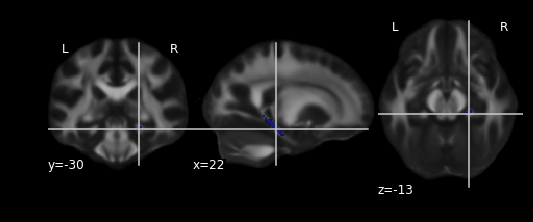

In [125]:
plotting.plot_roi(forceps_major_res.outputs.out_file, bg_img=template)

In [126]:
# apply the mni2dwi_warp to the forceps_major
forceps_major_sub = fsl.ApplyWarp(in_file=forceps_major_res.outputs.out_file, 
                                  ref_file=fa_file,
                                  interp='nn',
                                  field_file=invwarp_res.outputs.inverse_warp,
                                  out_file='sub-999_forceps_major.nii.gz')

display(forceps_major_sub.cmdline)
forceps_major_sub_res = forceps_major_sub.run()

'applywarp --in=/home/james/dipy_test/forceps_major.nii.gz --ref=/home/james/dipy_test/fa_preproc.nii.gz --out=sub-999_forceps_major.nii.gz --warp=/home/james/dipy_test/mni2dwi_warp.nii.gz --interp=nn'

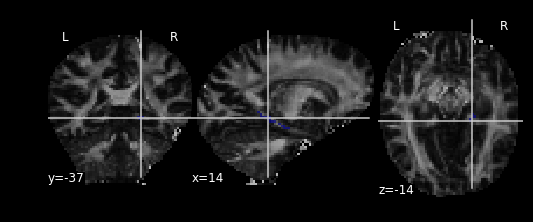

In [127]:
plotting.plot_roi(forceps_major_sub_res.outputs.out_file, bg_img=fa_file)

In [128]:
# extract the average FA from the Forceps Major
forceps_major_fa = fsl.ImageStats(in_file=fa_file, 
                                  mask_file=forceps_major_sub_res.outputs.out_file,
                                  op_string='-M')

display(forceps_major_fa.cmdline)
forceps_major_fa_res = forceps_major_fa.run()

'fslstats /home/james/dipy_test/fa_preproc.nii.gz -M '

180417-19:50:18,200 interface INFO:
	 stdout 2018-04-17T19:50:18.200639:0.243785 


In [129]:
# display the result
forceps_major_fa_res.outputs.out_stat

0.243785

## Problem Set

1) Let's see how preprocessing has impacted our results. Instead of doing all the preprocessing, let's use the raw unprocessed data instead. 
        - the raw dwi file is here: ./sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.nii.gz
        - the raw bvec file is here: ./sub-999/ses-activepre/dwi/sub-999_ses-activepre_dwi.bvec
The output will be the average FA of the Forceps Major (processed forceps_major_FA_ave = 0.243785)

In [ ]:
# code here

2) Choose another tract you are interested in and calculate the average FA of that region.

Outputs:
- Plot the region you chose in both MNI and subject space like we did in lab.
- The FA statistic from the region you chose

In [ ]:
# code here